In [1]:
# %matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import pendulum

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [5]:
# reflect an existing database into a new model
# Reflect Database into ORM classes
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)



In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
# Measurements
Measurements = Base.classes.measurement
# Stations
Stations = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurements.date).order_by(Measurements.date.desc()).first()[0]

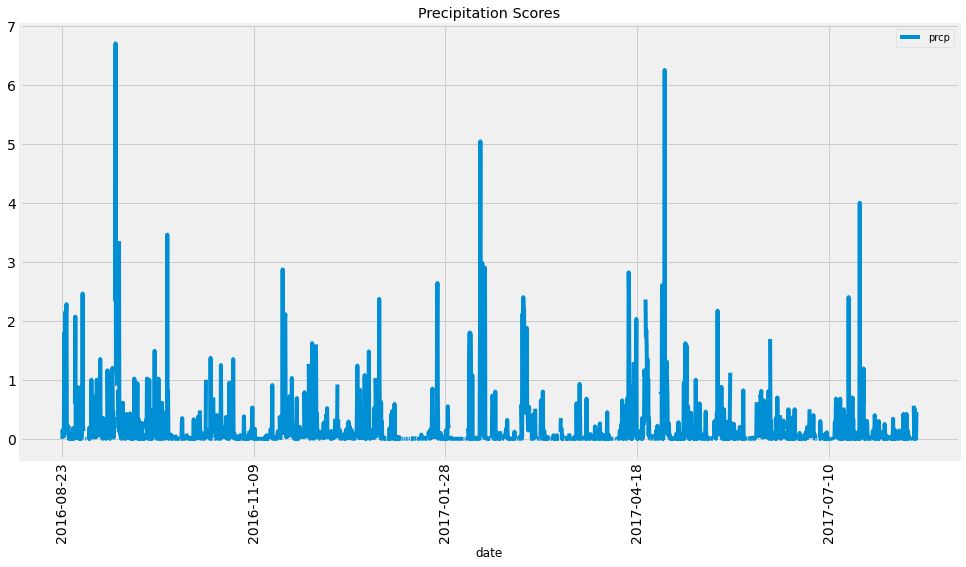

In [48]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
dt = pendulum.parse(most_recent_date)  # creating a DataTime object type using pendulum module

# Calculate the date one year from the last date in data set.
previous_year = dt.subtract(years=1).to_date_string()

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurements.date, Measurements.prcp).filter(Measurements.date >= previous_year).\
    order_by(Measurements.date).statement

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.read_sql_query(results, session.bind)
df.set_index("date", inplace=True)

# Sort the dataframe by date
df.sort_values(by='date', ascending=True, inplace= True)

# Use Pandas Plotting with Matplotlib to plot the data
ax = df.plot(rot=90, title="Precipitation Scores", figsize=(15,8), fontsize=14);



In [26]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset


In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close session

In [18]:
# Close Session
session.close()